In [1]:
import tensorflow as tf
import os

In [2]:
#This avoids OOM errors as tf will use the entirety of the GPU VRAM available, which could cause issues
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
import cv2
import imghdr

In [4]:
data_dir='data'

In [5]:
img_exts=['jpeg','jpg','bmp','png']

In [6]:
#Loops through each and every image in the data folder and removes the ones not matching our specified format above in img_exts
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path=os.path.join(data_dir,image_class,image)
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path)
            if tip not in img_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [7]:
tf.data.Dataset??


Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
@six.add_metaclass(abc.ABCMeta)
class DatasetV2(collections_abc.Iterable, tracking_base.Trackable,
                composite_tensor.CompositeTensor):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Ten

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [51]:
#Creates the data pipeline for us, an API of tensorflow
data=tf.keras.utils.image_dataset_from_directory('data')

Found 182 files belonging to 2 classes.


In [10]:
#Converting the pipeline as an iterator for better access of each elements
data_iterator=data.as_numpy_iterator()

In [19]:
#Used to traverse through the iterator as batches, batch consists of 2 parts, one consists the data for the image, and the other consists of all the labels
batch=data_iterator.next()

In [20]:
#Images represented as numpy arrays
batch[0].shape


(32, 256, 256, 3)

In [21]:
#0=Melanoma Cancer 1=Non-Melanoma Cancer
batch[1]

array([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

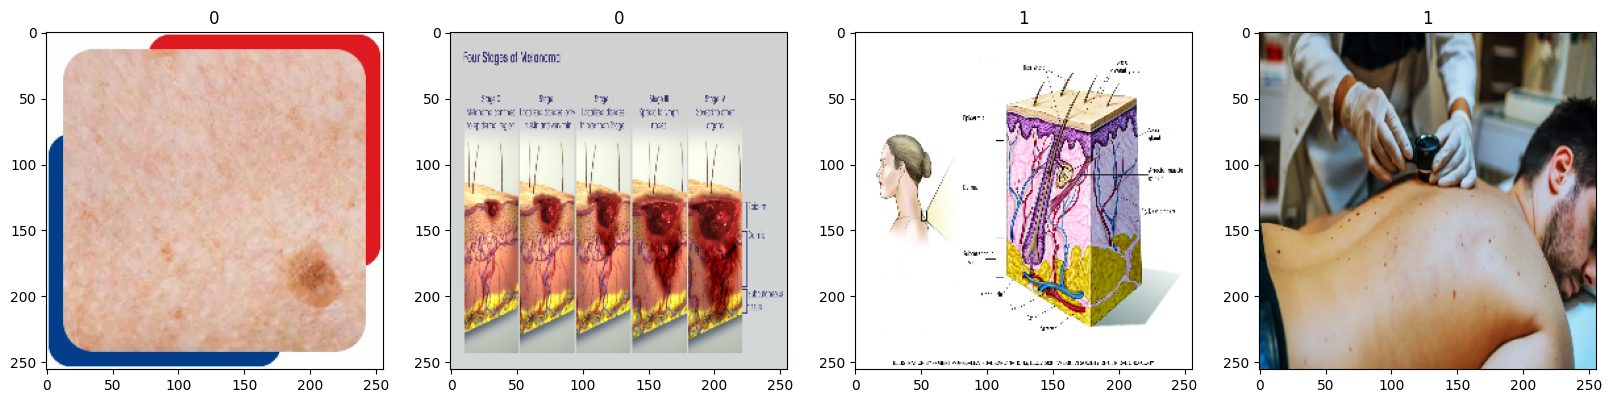

In [22]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [52]:
#Scaling data (scaling x from 0-255 to  0-1)
data=data.map(lambda x,y: (x/255,y))

In [57]:
iter=data.as_numpy_iterator()
btch=iter.next()
btch[0].max()


1.0

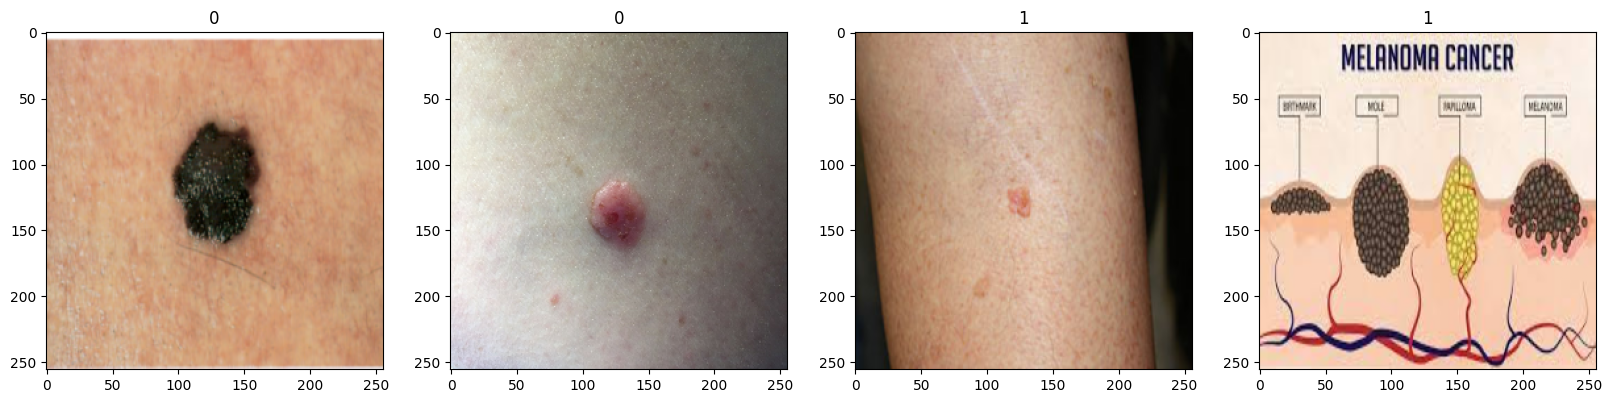

In [58]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(btch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [59]:
#Splitting the dataset
len(data)

6

In [67]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)+1

In [70]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [72]:
#Building the model
#Importing our model and various layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [73]:
model=Sequential()

In [74]:
#Conv2D -> 16 stands for the numbers of filters, (3,3) stands for the size of each filter, 1 is the stride ie how many pixels will be passed to each filter
model.add(Conv2D(16, (3,3),1, activation='relu',input_shape=(256,256,3))) 
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [79]:
#Training
logdir='logs'

In [80]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 55s 363ms/step - loss: 1.6047 - accuracy: 0.4609 - val_loss: 0.6079 - val_accuracy: 0.5938
Epoch 2/20
4/4 [==============================] - 2s 308ms/step - loss: 0.7627 - accuracy: 0.5078 - val_loss: 0.7327 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 294ms/step - loss: 0.6963 - accuracy: 0.5156 - val_loss: 0.6725 - val_accuracy: 0.5625
Epoch 4/20
4/4 [==============================] - 1s 245ms/step - loss: 0.7076 - accuracy: 0.5234 - val_loss: 0.7200 - val_accuracy: 0.4375
Epoch 5/20
4/4 [==============================] - 1s 245ms/step - loss: 0.6797 - accuracy: 0.5078 - val_loss: 0.6848 - val_accuracy: 0.3750
Epoch 6/20
4/4 [==============================] - 1s 234ms/step - loss: 0.6772 - accuracy: 0.6094 - val_loss: 0.6670 - val_accuracy: 0.6875
Epoch 7/20
4/4 [==============================] - 1s 244ms/step - loss: 0.6773 - accuracy: 0.5156 - val_loss: 0.6708 - val_accuracy: 0.4375
Epoch 8/20
4/4 [===

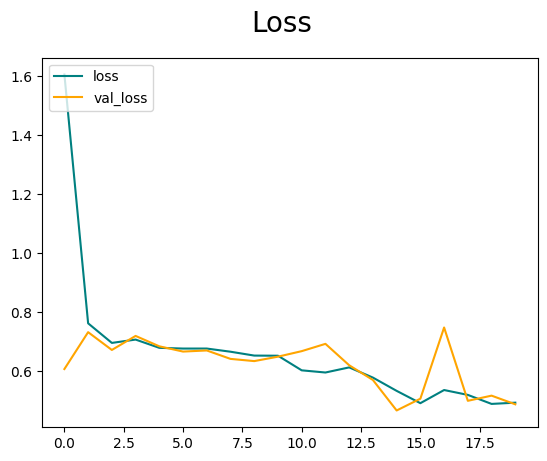

In [85]:
#Plotting Performance
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

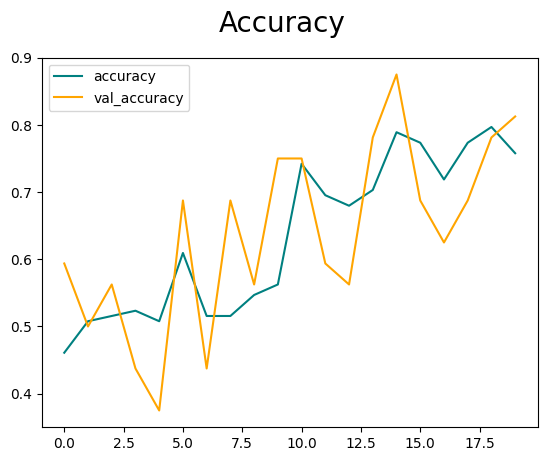

In [86]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [87]:
#Evaluate Performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [88]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [89]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 615ms/step


In [90]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.73333335, shape=(), dtype=float32) tf.Tensor(0.8181818, shape=(), dtype=float32)


In [91]:
import cv2

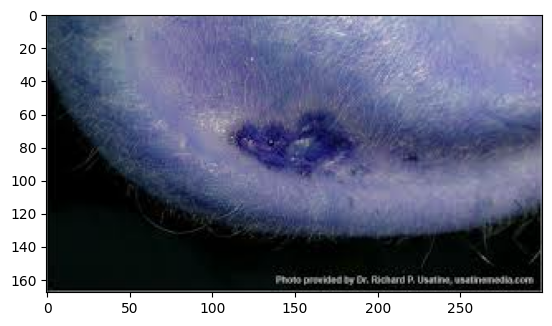

In [93]:
img = cv2.imread('nonmelanomatest.jpeg')
plt.imshow(img)
plt.show()

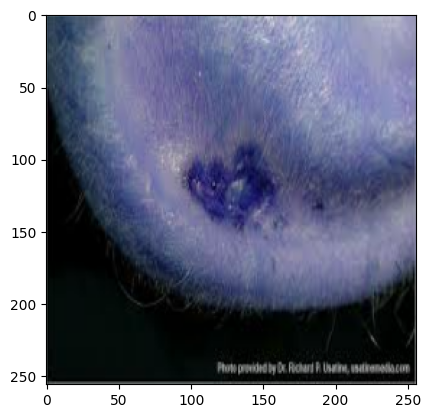

In [94]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [95]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 423ms/step


In [96]:
yhat

array([[0.8019437]], dtype=float32)

In [98]:
if yhat > 0.5: 
    print(f'Predicted class is Non Melanoma Cancer')
else:
    print(f'Predicted class is Melanoma Cancer')

Predicted class is Non Melanoma Cancer


In [99]:
#Save the model
from tensorflow.keras.models import load_model

In [100]:

model.save(os.path.join('models','melanomaclassifier.h5'))

In [101]:
new_model=load_model(os.path.join('models','melanomaclassifier.h5'))

In [102]:

new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 56ms/step


array([[0.8019437]], dtype=float32)